In [1]:
## System
import sys
import os
from collections import defaultdict

## Pandas
import pandas as pd
import numpy as np

## Plotting 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
import seaborn as sns

## Fig utils 
from fig_utils import (get_decile_score, 
                       deciles)


In /Users/michaelcormier/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/michaelcormier/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/michaelcormier/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
## genic ConSplice file path
autosome_genic_consplice_file = "../data/ConSplice.gene.scores.autosome.txt"
chrx_genic_consplice_file = "../data/ConSplice.gene.scores.chrX.txt"

In [3]:
## score columns
consplice_col = "weighted_sc_percentile"

In [4]:
## Read in the genic ConSplice scores into pandas data frame
autosome_ConSplice_df = pd.read_csv(autosome_genic_consplice_file, sep = "\t", index_col = False)
chrx_ConSplice_df = pd.read_csv(chrx_genic_consplice_file, sep = "\t", index_col = False)
ConSplice_df = pd.concat([autosome_ConSplice_df,chrx_ConSplice_df])

In [5]:
## Load tolerated Homozygous LoF gene sets

homozygou_lof_tolerant_genes = "../data/Hom.LoF_tolerant.genes.tsv"
with open(homozygou_lof_tolerant_genes) as lof_tol:
    hom_lof_tol = [x.strip() for x in lof_tol]

hom_lof_tol_list = []

hom_lof_tol_list.extend([[gene,"Homozygous LOF Tolerant (gnomAD)"] for gene in hom_lof_tol])

hom_lof_tol_df = pd.DataFrame(hom_lof_tol_list, columns = ["gene","gene_list"])

In [6]:
## Add ConSplice scores to gene df

o_e_gene_set = set(ConSplice_df.gene_symbol)
hom_lof_tol_df["ConSplice"] = hom_lof_tol_df.gene.apply(lambda x: ConSplice_df.loc[ConSplice_df.gene_symbol == x][consplice_col].values[0] if x in o_e_gene_set else "Missing" )

In [7]:
hom_lof_tol_df.groupby("gene_list").describe()

gene                     ConSplice         \
                                 count unique     top freq     count unique   
gene_list                                                                     
Homozygous LOF Tolerant (gnomAD)  1815   1815  PEX11G    1      1815   1436   

                                                
                                      top freq  
gene_list                                       
Homozygous LOF Tolerant (gnomAD)  Missing  380

In [8]:
## Bin scores and and combine dfs

hom_lof_tol_df["constraint_decile"] = hom_lof_tol_df.ConSplice.apply(get_decile_score)

ConSplice_df["constraint_decile"] = ConSplice_df.weighted_sc_percentile.apply(get_decile_score)

count_df = pd.merge(hom_lof_tol_df.groupby("constraint_decile").gene.count().reset_index().rename(columns = {"gene":"hom_lof_genes"}),
                    ConSplice_df.groupby("constraint_decile").gene_symbol.count().reset_index().rename(columns = {"gene_symbol":"total_genes"}),
                    on = "constraint_decile")

In [9]:
## Get percent of gene per bin
count_df["proprotion_hom_lof"] = count_df.hom_lof_genes / count_df.total_genes

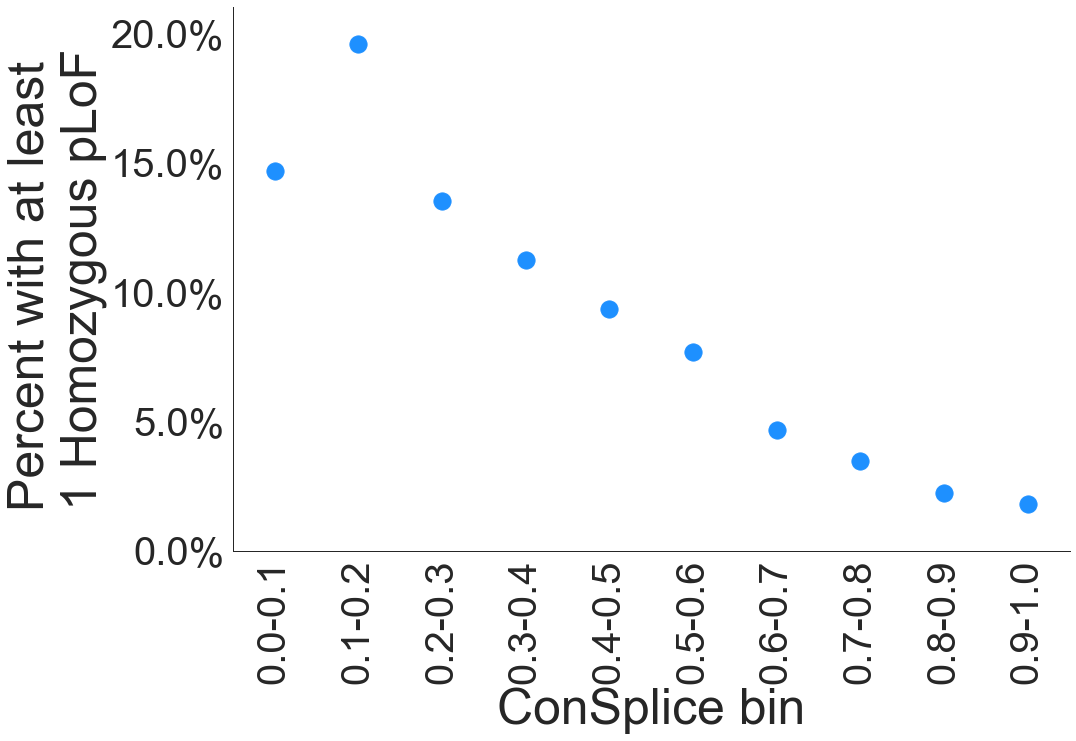

In [11]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

fig, ax = plt.subplots(figsize = (15,10))
sns.set(font='Arial', style = "white")
sns.set_context("paper", font_scale = 2)
sns.despine()

plt.scatter( x = count_df.constraint_decile, y =  count_df.proprotion_hom_lof * 100, s = 300, color = "dodgerblue")

plt.ylim(-0.02, 21)
plt.xlabel("ConSplice bin", fontsize = 50)
plt.ylabel("Percent with at least \n1 Homozygous pLoF", fontsize = 50)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.tick_params(axis="x", labelsize=40, rotation = 90 )
ax.tick_params(axis="y", labelsize=40) 

ax.set_xlim(-0.5,9.5)


plt.savefig('../figures/suppl_figure3_D.svg')